In [49]:
import networkx as nx
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import NEMtropy as nem
import numpy as np
import re

In [50]:
# Load the datasets from the assignment_1_data folder
path = "World_Trade_Web/"
files = [f for f in listdir(path) if isfile(join(path, f))]
gmls = [nx.read_graphml(path + f) for f in files]

graphs = {k: v for k, v in zip(files, gmls)}

In [51]:
def calc_strength_assortativity(G, directed):
    strength_assortativity = {}
    if not directed:
        strength_assortativity["undirected"] = nx.degree_pearson_correlation_coefficient(G, weight="weight")
    else:
        for d1 in ["in", "out"]:
            for d2 in ["in", "out"]:
                strength_assortativity[d1 + "-" + d2] = nx.assortativity.degree_pearson_correlation_coefficient(G, d1, d2, weight="weight")
    return strength_assortativity

In [85]:
dir_strength_assortativities = {graph_name: calc_strength_assortativity(G, directed=True) for graph_name, G in graphs.items()}

### 1. Compute the strength assortativity coefficient on the data.

In [86]:
print("Directed Strength assortativities:")
for graph_name, strength_assortativity in dir_strength_assortativities.items():
    print(graph_name)
    print(strength_assortativity)
    print()

Directed Strength assortativities:
WDN_1992.txt.graphml
{'in-in': -0.04868776409103536, 'in-out': -0.046647404340923966, 'out-in': -0.05986979308699118, 'out-out': -0.057603189205412596}

WDN_1993.txt.graphml
{'in-in': -0.06537929984057989, 'in-out': -0.062189867187615135, 'out-in': -0.07202068872957684, 'out-out': -0.06910618411247661}

WDN_1994.txt.graphml
{'in-in': -0.07868988970611814, 'in-out': -0.07622523439269749, 'out-in': -0.08022501617948014, 'out-out': -0.07800143058821372}

WDN_1995.txt.graphml
{'in-in': -0.07921393553292655, 'in-out': -0.07702100817504165, 'out-in': -0.07830645801950548, 'out-out': -0.07638722326404503}

WDN_1996.txt.graphml
{'in-in': -0.07686964594098036, 'in-out': -0.07546909805023265, 'out-in': -0.0753550251241622, 'out-out': -0.07420828746119316}

WDN_1997.txt.graphml
{'in-in': -0.07368635207387673, 'in-out': -0.07132955497657749, 'out-in': -0.07171683897072373, 'out-out': -0.0697007987200938}

WDN_1998.txt.graphml
{'in-in': -0.06557057818395692, 'in-o

### 2. Fit the Undirected Enhanced CM and Directed Enhanced CM using the CReMa method

In [55]:
def fit_UECM(graph):
    adjacency = nx.to_numpy_array(graph, weight="weight")
    adjacency_sym = adjacency + adjacency.T
    adjacency_bin = adjacency_sym.astype(bool).astype(float)
    strength_seq = adjacency.sum(axis=1)
    und_graph_weighted = nem.UndirectedGraph(strength_sequence=strength_seq)
    und_graph_weighted.solve_tool(
        model="crema",
        method="newton",
        initial_guess="random",
        adjacency=adjacency_bin,
        max_steps=10000,
        verbose=False,
    )
    return und_graph_weighted

def fit_DECM(graph):
    adjacency = nx.to_numpy_array(graph, weight="weight")
    adjacency_bin = adjacency.astype(bool).astype(float)
    out_strength = adjacency.sum(axis=1)
    in_strength = adjacency.sum(axis=0)
    dir_graph_weighted = nem.DirectedGraph(strength_sequence=np.concatenate([out_strength, in_strength]))
    dir_graph_weighted.solve_tool(
        model="crema",
        method="newton",
        initial_guess="random",
        adjacency=adjacency_bin,
        max_steps=10000,
        verbose=False,
    )
    return dir_graph_weighted

In [57]:
decms = {}
uecms = {}

for graph_name, G in graphs.items():
    decms[graph_name] = fit_DECM(G)
    uecms[graph_name] = fit_UECM(G)

c:\Users\paull\miniconda3\envs\network_science\lib\site-packages\numba\core\utils.py:613: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  category=NumbaExperimentalFeatureWarning)



solution error = 507824.95471191406

solution error = 36.866623499430716

solution error = 317190.2514038086

solution error = 276.03061378002167

solution error = 438468.02056884766

solution error = 290.91844564676285

solution error = 47901.029052734375

solution error = 0.642089519649744

solution error = 189488.2491455078

solution error = 1180.0908752381802

solution error = 372471.93896484375

solution error = 82.95035356283188

solution error = 358062.93127441406

solution error = 8324.07850446552

solution error = 433647.8996582031

solution error = 259.890631057322

solution error = 38962.69287109375

solution error = 0.07475346326828003

solution error = 49753.025146484375

solution error = 13673.682070732117

solution error = 300112.62243652344

solution error = 1.5506488382816315


In [58]:
for graph_name, cm in decms.items():
    print(graph_name + " | DECM | error degree " + str(cm.error_degree) + " | error strength " + str(cm.error_strength))

WDN_1992.txt.graphml | DECM | error degree None | error strength 507824.95471191406
WDN_1993.txt.graphml | DECM | error degree None | error strength 317190.2514038086
WDN_1994.txt.graphml | DECM | error degree None | error strength 438468.02056884766
WDN_1995.txt.graphml | DECM | error degree None | error strength 47901.029052734375
WDN_1996.txt.graphml | DECM | error degree None | error strength 189488.2491455078
WDN_1997.txt.graphml | DECM | error degree None | error strength 372471.93896484375
WDN_1998.txt.graphml | DECM | error degree None | error strength 358062.93127441406
WDN_1999.txt.graphml | DECM | error degree None | error strength 433647.8996582031
WDN_2000.txt.graphml | DECM | error degree None | error strength 38962.69287109375
WDN_2001.txt.graphml | DECM | error degree None | error strength 49753.025146484375
WDN_2002.txt.graphml | DECM | error degree None | error strength 300112.62243652344


In [59]:
for graph_name, cm in uecms.items():
    print(graph_name + " | UECM | error degree " + str(cm.error_degree) + " | error strength " + str(cm.error_strength))

WDN_1992.txt.graphml | UECM | error degree None | error strength 36.866623499430716
WDN_1993.txt.graphml | UECM | error degree None | error strength 276.03061378002167
WDN_1994.txt.graphml | UECM | error degree None | error strength 290.91844564676285
WDN_1995.txt.graphml | UECM | error degree None | error strength 0.642089519649744
WDN_1996.txt.graphml | UECM | error degree None | error strength 1180.0908752381802
WDN_1997.txt.graphml | UECM | error degree None | error strength 82.95035356283188
WDN_1998.txt.graphml | UECM | error degree None | error strength 8324.07850446552
WDN_1999.txt.graphml | UECM | error degree None | error strength 259.890631057322
WDN_2000.txt.graphml | UECM | error degree None | error strength 0.07475346326828003
WDN_2001.txt.graphml | UECM | error degree None | error strength 13673.682070732117
WDN_2002.txt.graphml | UECM | error degree None | error strength 1.5506488382816315


### 3. Sample 30 networks from the obtained ERGM distributions and measure the strength assortativity on all of them.

In [17]:
path = "decm_samples_"
for graph_name, cm in decms.items():
    cm.ensemble_sampler(n=30, output_dir=path + graph_name + "/")

In [66]:
path = "decm_samples_"
decm_sample_networks = {}
for graph_name in decms.keys():
    decm_sample_networks[graph_name] = []
    files = [f for f in listdir(path + graph_name) if isfile(join(path + graph_name, f))]
    edgelist_ens = [np.loadtxt(path + graph_name + "/" + f) for f in files]

    for e in edgelist_ens:
        ens_adj = nem.network_functions.build_adjacency_from_edgelist(edgelist = e,
                                                is_directed = True,
                                                is_sparse = False,
                                                is_weighted = True)
        decm_sample_networks[graph_name].append(nx.from_numpy_array(ens_adj, create_using=nx.DiGraph))

In [67]:
path = "uecm_samples_"
for graph_name, cm in uecms.items():
    cm.ensemble_sampler(n=30, output_dir=path + graph_name + "/")

In [68]:
uecm_sample_networks = {}
path = "uecm_samples_"

for graph_name in uecms.keys():
    uecm_sample_networks[graph_name] = []
    files = [f for f in listdir(path + graph_name) if isfile(join(path + graph_name, f))]
    edgelist_ens = [np.loadtxt(path + graph_name + "/" + f) for f in files]

    for i, e in enumerate(edgelist_ens):
        ens_adj = nem.network_functions.build_adjacency_from_edgelist(edgelist = e,
                                                is_directed = False,
                                                is_sparse = False,
                                                is_weighted = True)
        uecm_sample_networks[graph_name].append(nx.from_numpy_array(ens_adj))

In [29]:
def calc_strength_assortativity_avg_std(ens, directed):
    strength_assortativity_avg_std = {}
    if not directed:
        key = "undirected"
        values = [calc_strength_assortativity(G, directed=directed)[key] for G in ens]
        strength_assortativity_avg_std[key] = {
            "average": np.mean(values),
            "standard deviation": np.std(values),
        }
    else:
        for d1 in ["in", "out"]:
            for d2 in ["in", "out"]:
                key = f"{d1}-{d2}"
                values = [calc_strength_assortativity(G, directed=directed)[key] for G in ens]

                strength_assortativity_avg_std[key] = {
                    "average": np.mean(values),
                    "standard deviation": np.std(values),
                }
    return strength_assortativity_avg_std

In [76]:
def calc_strength_assortativity_avg_std(param_ens, directed):
    strength_assortativity_avg_std = {}
    strength_assortativities = [calc_strength_assortativity(G, directed=directed) for G in param_ens]
    for key in strength_assortativities[0]:
        strength_assortativity_avg_std[key] = {}
        strength_assortativity_avg_std[key]["average"] = np.mean([v[key] for v in strength_assortativities])
        strength_assortativity_avg_std[key]["standard deviation"] = np.std([v[key] for v in strength_assortativities])
    return strength_assortativity_avg_std

###  Calculate average and standard deviation of each assortativity typology.

In [73]:
uecm_sample_networks_strength_assortativity_avg_std = {}

for graph_name, ens in uecm_sample_networks.items():
    uecm_sample_networks_strength_assortativity_avg_std[graph_name] = calc_strength_assortativity_avg_std(ens, directed=False)

In [74]:
print("UECM sample networks strength assortativities:")
for graph_name, strength_assortativity in uecm_sample_networks_strength_assortativity_avg_std.items():
    print(graph_name)
    print(strength_assortativity)
    print()

UECM sample networks strength assortativities:
WDN_1992.txt.graphml
{'undirected': {'average': -0.07623317032391864, 'standard deviation': 0.021378529722667315}}

WDN_1993.txt.graphml
{'undirected': {'average': -0.09524998059323747, 'standard deviation': 0.016280613238872074}}

WDN_1994.txt.graphml
{'undirected': {'average': -0.08872229188232797, 'standard deviation': 0.017537085354760257}}

WDN_1995.txt.graphml
{'undirected': {'average': -0.08250110780171625, 'standard deviation': 0.01807530575021957}}

WDN_1996.txt.graphml
{'undirected': {'average': -0.07561604465635577, 'standard deviation': 0.01408772940247878}}

WDN_1997.txt.graphml
{'undirected': {'average': -0.0657474801880186, 'standard deviation': 0.012094060219007554}}

WDN_1998.txt.graphml
{'undirected': {'average': -0.06806601131055333, 'standard deviation': 0.009986087578798158}}

WDN_1999.txt.graphml
{'undirected': {'average': -0.06347545065080025, 'standard deviation': 0.01395825094504728}}

WDN_2000.txt.graphml
{'undire

In [78]:
decm_sample_networks_strength_assortativity_avg_std = {}

for graph_name, dir_ens in decm_sample_networks.items():
    decm_sample_networks_strength_assortativity_avg_std[graph_name] = calc_strength_assortativity_avg_std(dir_ens, directed=True)

In [79]:
print("Strength assortativities:")
for graph_name, strength_assortativity in decm_sample_networks_strength_assortativity_avg_std.items():
    print(graph_name)
    print(strength_assortativity)
    print()

Strength assortativities:
WDN_1992.txt.graphml
{'in-in': {'average': -0.048309781412972375, 'standard deviation': 0.008501660356508853}, 'in-out': {'average': -0.044856990587177355, 'standard deviation': 0.009978730127802822}, 'out-in': {'average': -0.055578036780768024, 'standard deviation': 0.010685271140185956}, 'out-out': {'average': -0.0545080796038778, 'standard deviation': 0.010919349423514585}}

WDN_1993.txt.graphml
{'in-in': {'average': -0.061864552584063315, 'standard deviation': 0.010392169112388395}, 'in-out': {'average': -0.0556151751339181, 'standard deviation': 0.010648275364166002}, 'out-in': {'average': -0.06474691484226516, 'standard deviation': 0.01243095011164148}, 'out-out': {'average': -0.06191961159376424, 'standard deviation': 0.012694552491279003}}

WDN_1994.txt.graphml
{'in-in': {'average': -0.0705803571813435, 'standard deviation': 0.013758486043204}, 'in-out': {'average': -0.06660859246378924, 'standard deviation': 0.014430995307928102}, 'out-in': {'average'

### 4. Plot strength assortativity as a function of time (the WTW network year), comparing the observed real value with the average and error bars obtained from the samples samples.

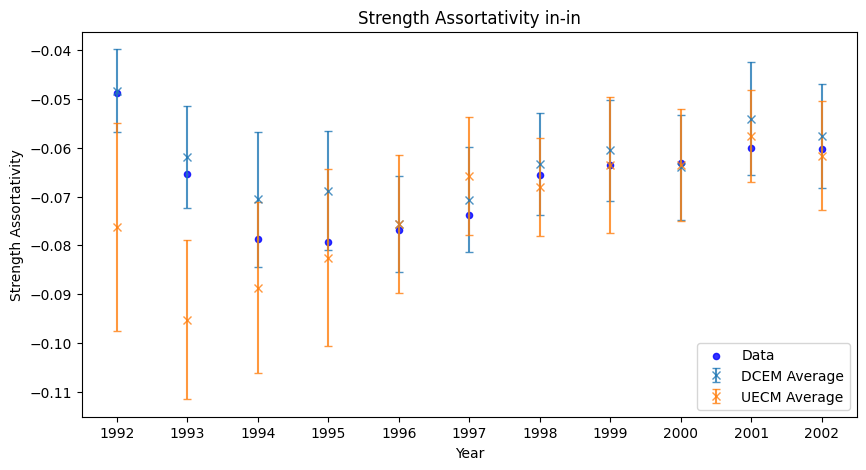

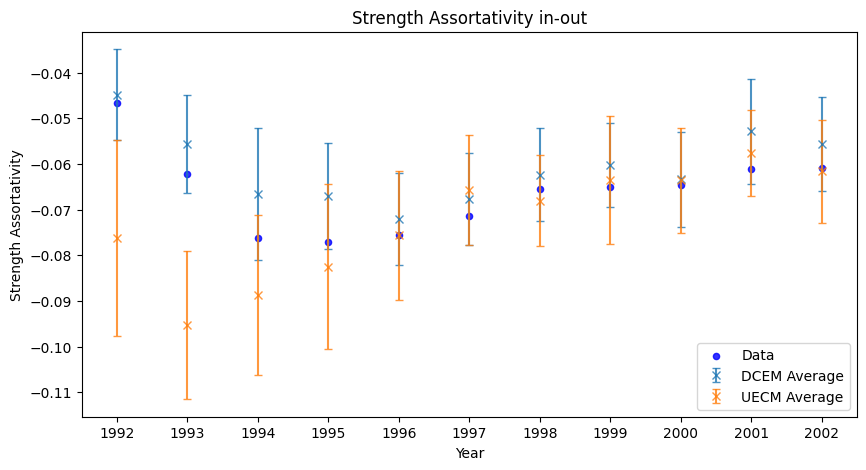

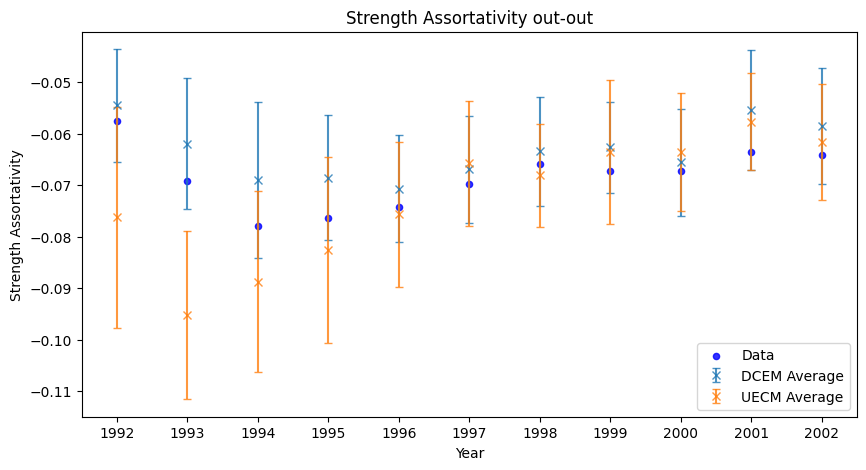

In [107]:
# Assuming you have obtained these values from your calculations
graph_names = list(graphs.keys())  # Replace with your actual years
real_values = dir_strength_assortativities  # Replace with your actual observed strength assortativities
decm_avg_std_values = decm_sample_networks_strength_assortativity_avg_std # Replace with your calculated average and standard deviation values
uecm_avg_std_values = uecm_sample_networks_strength_assortativity_avg_std # Replace with your calculated average and standard deviation values


# Function to plot strength assortativity with error bars
def plot_strength_assortativity(assortativity_type):
    key = f"{assortativity_type[0]}-{assortativity_type[1]}"

    real_data = np.array([real_values[graph_name][key] for graph_name in graph_names])
    decm_avg_data = np.array([decm_avg_std_values[graph_name][key]['average'] for graph_name in graph_names])
    decm_std_data = np.array([decm_avg_std_values[graph_name][key]['standard deviation'] for graph_name in graph_names])
    uecm_avg_data = np.array([uecm_avg_std_values[graph_name]['undirected']['average'] for graph_name in graph_names])
    uecm_std_data = np.array([uecm_avg_std_values[graph_name]['undirected']['standard deviation'] for graph_name in graph_names])

    years = [re.search(r'\d+', graph_name).group() for graph_name in graph_names]
    plt.figure(figsize=(10,5))
    plt.scatter(years, real_data, label="Data", s=20, alpha=0.8,color='blue')
    plt.errorbar(years, decm_avg_data, yerr=decm_std_data, label='DCEM Average', alpha=0.8, fmt = 'x',capsize=3)
    plt.errorbar(years, uecm_avg_data, yerr=uecm_std_data, label='UECM Average', alpha=0.8, fmt = 'x',capsize=3)
    
    plt.xlabel('Year')
    plt.ylabel('Strength Assortativity')
    plt.title(f'Strength Assortativity {assortativity_type[0]}-{assortativity_type[1]}')
    plt.legend()
    plt.show()

for assortativity_type in [("in", "in"), ("in", "out"), ("out", "out")]:
    plot_strength_assortativity(assortativity_type)

### 5. Write a short paragraph to comment on the interpretation of strength assortativity for this dataset, and about the conclusions you can draw via the inference you made using the ERGM models.

With respect to strength assortativity the network can be said well represented by the directed configuration model.

In general, with respect to the data, a high strength assortativity would represent a high amount of trades between countries and a low strength assortativity would depict a low volume between countries. This can be well represented by weights in a network, accordingly there is just a small gap between the real-world values and the directed enhanced cm.
Since the undirected enhance configuration model does not take the direction into account, the gap is a little larger but still in the single digit area. Accordingly also not bad.

Now, strength assortativity works really good as a metric, but this does not necessarily imply that the same holds for another metric. If you'd look at degree centrality or clustering, for example, this might look completely different. Therefore, it's not possible to make a general statement.